In [1]:
# Download dataset
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet

fatal: destination path 'Brain-Tumor-Classification-DataSet' already exists and is not an empty directory.


In [2]:
# Import neccessary libraries
import pathlib
import os
import numpy as np
import pandas as pd
import random
import PIL.Image as image
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Import train set data

In [3]:
# Train set data directory
data_dir = pathlib.Path('/content/Brain-Tumor-Classification-DataSet/Training')

In [4]:
# Number of images in train set
train_image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'There are {train_image_count} images in train set.')

There are 2870 images in train set.


In [5]:
# Number of classes to classify
class_names = os.listdir(data_dir)
num_classes = len(class_names)

print(f'There are {num_classes} classes')
print(f'The names of the classes are {class_names}')

There are 4 classes
The names of the classes are ['meningioma_tumor', 'no_tumor', 'glioma_tumor', 'pituitary_tumor']


### Data Visualization

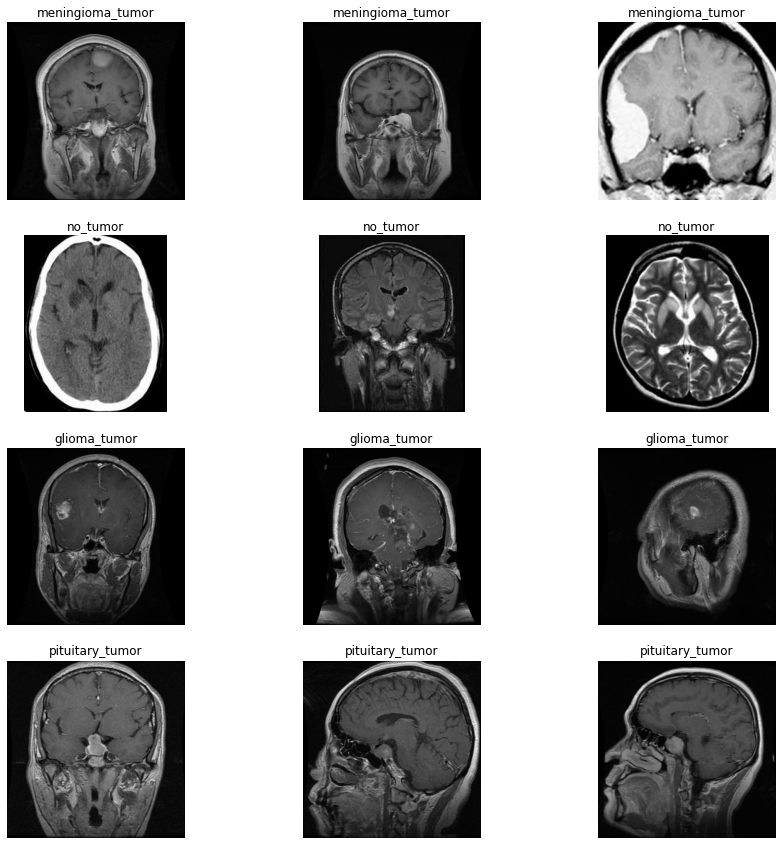

In [6]:
# Display 3 sample images from each class
img_cnt = []
plot_idx = 1
plt.figure(figsize=(15, 15))

for c in class_names:
    # Count number of images in a class
    class_dir = pathlib.Path(str(data_dir) +'/' + c)
    img_cnt.append(len(list(class_dir.glob('*.jpg'))))

    # Display image
    for i in range(3):
        ax = plt.subplot(4, 3, plot_idx+i)
        sample = list(data_dir.glob(str(c) + '/*'))
        im = image.open(str(sample[i]))
        plt.imshow(im)
        plt.title(c)
        plt.axis("off")
    
    plot_idx += 3

In [7]:
# Number of images in each class
num_images_in_class = pd.DataFrame(img_cnt, index=class_names, columns=["image count"])
num_images_in_class

,image count
meningioma_tumor,822
no_tumor,395
glioma_tumor,826
pituitary_tumor,827


The size of the 'no_tumor' class is significantly small than the other three classes.

In [8]:
# Image size
img_width, img_height = image.open(str(sample[0])).size
print(f'The size of the images are {img_width} x {img_height}')

The size of the images are 512 x 512


### Split train and validation datasets

In [9]:
# Train dataset

batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.


In [10]:
# Validation dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2870 files belonging to 4 classes.
Using 574 files for validation.


In [11]:
class_names = train_ds.class_names
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

### Build training model

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
# Build a base 2-layers model of Convolutional Neural Network

seed_value = 12321
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

model_2_layers = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
    
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [14]:
model_2_layers.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [15]:
model_2_layers.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
72/72 [==============================] - 15s 162ms/step - loss: 1.0362 - accuracy: 0.6272 - val_loss: 0.6359 - val_accuracy: 0.7300
Epoch 2/10
72/72 [==============================] - 9s 125ms/step - loss: 0.3215 - accuracy: 0.8868 - val_loss: 0.5568 - val_accuracy: 0.7944
Epoch 3/10
72/72 [==============================] - 9s 124ms/step - loss: 0.1271 - accuracy: 0.9569 - val_loss: 0.5030 - val_accuracy: 0.8484
Epoch 4/10
72/72 [==============================] - 9s 125ms/step - loss: 0.0413 - accuracy: 0.9895 - val_loss: 0.4666 - val_accuracy: 0.8728
Epoch 5/10
72/72 [==============================] - 9s 125ms/step - loss: 0.0204 - accuracy: 0.9930 - val_loss: 0.4849 - val_accuracy: 0.8798
Epoch 6/10
72/72 [==============================] - 9s 125ms/step - loss: 0.0327 - accuracy: 0.9895 - val_loss: 0.5597 - val_accuracy: 0.8624
Epoch 7/10
72/72 [==============================] - 9s 125ms/step - loss: 0.0172 - accuracy: 0.9943 - val_loss: 0.6183 - val_accuracy: 0.8780
Epoch

In [16]:
model_2_layers.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 186624)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

The train accuracy is 99.09% and the validation accuracy is 86.59%

### Evaluate model performance on the test dataset

In [17]:
data_dir = pathlib.Path('/content/Brain-Tumor-Classification-DataSet/Testing')

In [18]:
test_image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'There are {test_image_count} images in test set.')

There are 394 images in test set.


In [19]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=None,
    subset=None,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 394 files belonging to 4 classes.


In [20]:
test_loss, test_accuracy = model_2_layers.evaluate(test_ds, verbose=2)
print(f'The test accuracy is {test_accuracy*100:.2f}%')

13/13 - 1s - loss: 4.7983 - accuracy: 0.6751
The test accuracy is 67.51%


#### Accuracy evaluation:
2 layers model: <br>
Train accuracy: 99.09% <br>
Validation accuracy: 86.59% <br>
Test accuracy: 67.51% <br><br>
We see that the test accuracy is way lower than the train and validation accuracy.  The model is overfitting.  It learns the train set too well.  It performs well on the train set but not on the validation and test sets.  We will try to reduce overfitting by adding dropout layers to our model.

#### Adding dropout layers to reduce overfitting

In [21]:
model_2_layers_do = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.5, seed=seed_value),
    
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.5, seed=seed_value),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [22]:
model_2_layers_do.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [23]:
model_2_layers_do.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
72/72 [==============================] - 9s 110ms/step - loss: 2.1829 - accuracy: 0.4612 - val_loss: 1.2605 - val_accuracy: 0.4582
Epoch 2/10
72/72 [==============================] - 7s 97ms/step - loss: 0.9578 - accuracy: 0.5919 - val_loss: 0.9571 - val_accuracy: 0.5697
Epoch 3/10
72/72 [==============================] - 7s 98ms/step - loss: 0.6638 - accuracy: 0.7221 - val_loss: 0.8063 - val_accuracy: 0.6272
Epoch 4/10
72/72 [==============================] - 7s 97ms/step - loss: 0.4912 - accuracy: 0.7962 - val_loss: 0.6246 - val_accuracy: 0.7143
Epoch 5/10
72/72 [==============================] - 7s 97ms/step - loss: 0.3481 - accuracy: 0.8667 - val_loss: 0.6700 - val_accuracy: 0.7230
Epoch 6/10
72/72 [==============================] - 7s 97ms/step - loss: 0.2568 - accuracy: 0.9029 - val_loss: 0.4764 - val_accuracy: 0.8362
Epoch 7/10
72/72 [==============================] - 7s 97ms/step - loss: 0.1778 - accuracy: 0.9281 - val_loss: 0.5096 - val_accuracy: 0.8502
Epoch 8/10
7

We see that after adding the dropout layers, both the train accuracy and the validation accuracy go down a little.  The train accuracy is now 96.99% and the validation accuracy is 86.24%

In [24]:
# Evaludate test set
test_loss, test_accuracy = model_2_layers_do.evaluate(test_ds, verbose=2)
print(f'The test accuracy is {test_accuracy*100:.2f}%')

13/13 - 1s - loss: 3.0568 - accuracy: 0.7183
The test accuracy is 71.83%


The test accuracy is 71.83% which is a 6.4% improvement.

### Model evaluation

In [25]:
# Get the labels
predictions = np.array([])
true_lables = np.array([])

for x, y in test_ds:
    predictions = np.concatenate([predictions, np.argmax(model_2_layers_do.predict(x), axis=-1)])
    true_lables = np.concatenate([true_lables, y.numpy()])

# Look at the first 10 predictions and labels
print('predictions = ', predictions[:10])
print('True labels = ', true_lables[:10])

predictions =  [2. 2. 1. 1. 2. 1. 1. 3. 1. 2.]
True labels =  [2. 2. 1. 1. 2. 1. 0. 3. 1. 0.]


In [26]:
# Verify the test accuracy
m = tf.keras.metrics.Accuracy()
m(true_lables, predictions).numpy()

0.7182741

In [27]:
# Confusion matrix
cm = tf.math.confusion_matrix(true_lables, predictions)
print('Confusion matrix:', cm)

Confusion matrix: tf.Tensor(
[[18 19 54  9]
 [ 1 97 13  4]
 [ 3  3 98  1]
 [ 0  4  0 70]], shape=(4, 4), dtype=int32)


In [28]:
# Classification Report
print('Classification Report:\n')
print(classification_report(true_lables, predictions, target_names=class_names))

Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.82      0.18      0.30       100
meningioma_tumor       0.79      0.84      0.82       115
        no_tumor       0.59      0.93      0.73       105
 pituitary_tumor       0.83      0.95      0.89        74

        accuracy                           0.72       394
       macro avg       0.76      0.73      0.68       394
    weighted avg       0.75      0.72      0.67       394



From the confusion matrix and the classification report, we see that the model has pretty good recall rates on the pituitary tumor class and no tumor classes.  The meningioma tumor class has a decent recall rate also.  However, the model does not perform well on the glioma tumor class.  The recall rate is only 18%.  The model misses most of the positive cases for this class.